<a href="https://colab.research.google.com/github/RomanGustavo/Mestrado---ML/blob/main/codigo_aula23_classificacao_desbalanceada_ROC_AUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação desbalanceada (Escolha do valor de limiar para classicação e cálculo das métricas ROC e AUC)

Esse notebook é uma tradução e adaptação do exemplo apresentado [no site do Keras](https://keras.io/examples/structured_data/imbalanced_classification/), criado por [fchollet](https://twitter.com/fchollet), e que utiliza essa base de dados do Kaggle [aqui](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).


## Introdução

Este exemplo mostra como treinar um modelo classificador quando os dados são altamente desbalanceados. O objetivo é treinar uma rede neural capaz de identificar operações financeiras fraudulentas.

## Vetorizando os dados CSV

In [6]:
import csv
import numpy as np

fname = "creditcard.csv"

todas_caracteristicas = []
todos_rotulos = []

with open(fname, "r", newline="", encoding="utf-8-sig") as f:
    # 1) Detecta delimitador (vírgula ou ponto-e-vírgula)
    sample = f.read(4096)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=",;")
    except csv.Error:
        dialect = csv.get_dialect("excel")
    f.seek(0)

    reader = csv.reader(f, dialect)
    header = next(reader)

    # 2) Normaliza cabeçalho (tira aspas/espacos) e acha o índice de 'Class'
    header = [h.strip().strip('"') for h in header]
    try:
        class_idx = header.index("Class")
    except ValueError:
        raise RuntimeError("Coluna 'Class' não encontrada no cabeçalho.")

    feat_idx = [i for i in range(len(header)) if i != class_idx]

    print("CABECALHO:", ",".join(header))

    for i, fields in enumerate(reader):
        # 3) Normaliza campos (tira aspas/espacos)
        fields = [c.strip().strip('"') for c in fields]

        # 4) Lê rótulo pela COLUNA 'Class' (não pela última posição)
        label_str = fields[class_idx]
        # aceita '0', '1', '0.0', '1.0'
        try:
            label = int(float(label_str))
            if label not in (0, 1):
                raise ValueError
        except ValueError:
            raise ValueError(f"Linha {i+2}: rótulo inválido na coluna 'Class': {label_str!r}")

        # 5) Lê features; tolera vírgula como separador decimal
        try:
            feat_row = [float(fields[j].replace(",", ".")) for j in feat_idx]
        except ValueError as e:
            raise ValueError(f"Linha {i+2}: erro convertendo features. Exemplo de valor: {fields[j]!r}") from e

        todos_rotulos.append([label])
        todas_caracteristicas.append(feat_row)

        if i == 0:
            print("CARACTERISTICAS:", feat_row)

caracteristicas = np.array(todas_caracteristicas, dtype="float32")
valores_alvo    = np.array(todos_rotulos, dtype="uint8")

print("caracteristicas.shape:", caracteristicas.shape)
print("valores_alvo.shape:", valores_alvo.shape)


CABECALHO: Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
CARACTERISTICAS: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
caracteristicas.shape: (284807, 30)
valores_alvo.shape: (284807, 1)


## Preparando os dados

In [7]:
num_amostras_validacao = int(len(caracteristicas) * 0.2) # deixaremos 20% dos dados para validação
X_trein = caracteristicas[:-num_amostras_validacao]
y_trein = valores_alvo[:-num_amostras_validacao]
X_val   = caracteristicas[-num_amostras_validacao:]
y_val   = valores_alvo[-num_amostras_validacao:]

print("Número de amostras de treinamento:", len(X_trein))
print("Número de amostras de validação:", len(X_val))

Número de amostras de treinamento: 227846
Número de amostras de validação: 56961


## Análise do desbalanceamento nos rótulos e atribuição de pesos diferentes

In [8]:
qtdade_amostras_cada_classe = np.bincount(y_trein[:, 0]) # função do numpy que conta a quantidade de amostras para cada classe
print(qtdade_amostras_cada_classe)
print(
    "Número de amostras positivas no conjunto de dados: {} ({:.2f}% do total)".format(
        qtdade_amostras_cada_classe[1], 100 * float(qtdade_amostras_cada_classe[1]) / len(y_trein)
    )
)

peso_classe_0 = 1.0 / qtdade_amostras_cada_classe[0]
peso_classe_1 = 1.0 / qtdade_amostras_cada_classe[1]

print("Peso para classe 0:", peso_classe_0 )
print("Peso para classe 1:", peso_classe_1 )

pesos_classes = {0: peso_classe_0, 1: peso_classe_1} # cria um dicionário com o peso de cada classe

[227429    417]
Número de amostras positivas no conjunto de dados: 417 (0.18% do total)
Peso para classe 0: 4.396976638863118e-06
Peso para classe 1: 0.002398081534772182


## Normalizando os dados usando média e desvio padrão

In [9]:
media    = np.mean(X_trein, axis=0)
X_trein -= media
X_val   -= media
desvio   = np.std(X_trein, axis=0)
X_trein /= desvio
X_val   /= desvio

## Criando uma rede neural para classificação binária

In [10]:
import keras

modelo = keras.Sequential(
    [
        keras.Input(shape=X_trein.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,777 (546.00 KB)

 Trainable params: 139,777 (546.00 KB)

 Non-trainable params: 0 (0.00 B)

## Treinando o modelo levando em conta o desbalaceamento entre as classes

In [11]:
modelo.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy")

modelo.fit(
    X_trein,
    y_trein,
    batch_size=2048, # define a quantidade de amostras de cada "mini-lote" (se comentarmos essa linha, será usado o padrão de 32 amostras por mini-lote)
    epochs=30,
    class_weight=pesos_classes,
)

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2.5738e-06
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5472e-06
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2045e-06
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0246e-06
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5794e-07
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2279e-07
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4914e-07
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6248e-07
Epoch 9/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6887e-07
Epoch 10/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5766e-07
Epoch 11/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9431e-07
Epoch 12/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3868e-06
Epoch 13/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0512e-06
Epoch 14/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4691e-06


In [12]:
probabilidades = modelo.predict(X_val) # cálculo da saída da rede neural para as transações de validação

print(probabilidades.shape) # verificando o shape das probabilidades

print(probabilidades[:10])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
(56961, 1)
[[2.2155913e-18]
 [3.5803127e-18]
 [4.5441220e-14]
 [2.8025880e-04]
 [2.2030180e-02]
 [1.8532930e-06]
 [3.6489571e-04]
 [2.4393084e-14]
 [3.8418531e-02]
 [2.6574981e-14]]


In [19]:
valor_limiar = 0.64

y_val_est = (probabilidades >= valor_limiar).astype(int)

print(y_val_est.shape)
print(y_val_est[:10])

(56961, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


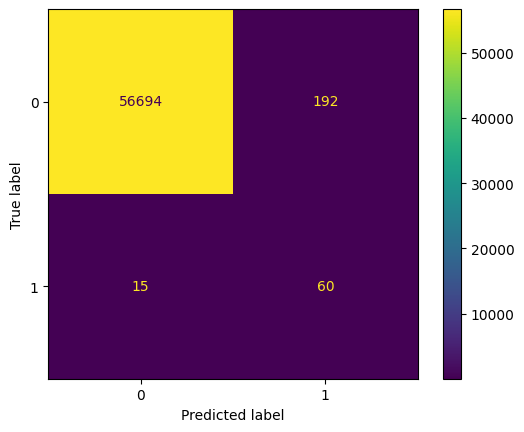

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()


A partir da matriz de confusão, gerada para as transações de validação, podemos perceber que (os valores abaixo podem variar ligeiramente devido à inicialização aleatória dos pesos da rede neural):

- 56961 transações de validação foram avalidadas pela rede neural
- 66 transações foram corretamente identificadas como fraudulentas
- 8 transações fraudulentas não foram detectadas
- Infelizmente, 441 transações não fraudulentas foram incorretamente classificadas como fraudulentas.


Abaixo iremos construir uma função que permite calcular a matriz de confusão e suas métricas para diferentes valores de limiar

In [22]:
def calcula_metricas(probabilidades, valor_limiar=0.5):

  y_val_est = (probabilidades >= valor_limiar).astype(int)

  cm = confusion_matrix(y_val, y_val_est) # cm = confusion matrix = matriz de confusão

  # calculando métricas relativas à matriz de confusão

  # faremos os cálculos abaixo levando em conta apenas a classe y=1 como sendo a classe "positiva" (classe de referência)
  # Note que a posição dos elementos na matriz de confusão obtida pela função "confusion_matrix" do sk learn é diferente daquela apresentada nos slides da aula.
  vp = cm[1,1] # verdadeiros positivos
  vn = cm[0,0] # verdadeiros negativos
  fp = cm[0,1] # falsos positivos
  fn = cm[1,0] # falsos negativos

  precisao  = vp / (vp + fp)
  revocacao = vp / (vp + fn)
  f1_score  = 2*precisao*revocacao / (precisao + revocacao)
  taxa_VP   = revocacao
  taxa_FP   = fp / (fp + vn)

  return precisao, revocacao, f1_score, taxa_VP, taxa_FP

In [23]:
valor_limiar = 0.5

precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)

print("precisão: ", precisao)

print("recall: ", revocacao)

print("F1 score: ", f1_score)

print("taxa de VP: ", taxa_VP)

print("taxa de FP: ", taxa_FP)

precisão:  0.1891891891891892
recall:  0.84
F1 score:  0.3088235294117648
taxa de VP:  0.84
taxa de FP:  0.004746334774812784


Note que é possível rodar a célula acima para diversos valores de limiar.

A célula abaixo faz isso sistematicamente.

In [24]:
passo = 0.02 # define o passo de incremento do valor de limiar
valores_limiar = np.arange(0, 1+passo, passo) # define valores de limiar de 0 a 1 crescendo no passo pré-estabelecido
taxas_VP = []
taxas_FP = []

linhas = []

for valor_limiar in valores_limiar:
  precisao, revocacao, f1_score, taxa_VP, taxa_FP = calcula_metricas(probabilidades, valor_limiar)
  linha = {'Valor limiar': valor_limiar, 'Taxa de VP': taxa_VP, 'taxa de FP': taxa_FP}
  linhas.append(linha)


# Abaixo nós transformamos a lista acima num pandas dataframe

import pandas as pd

# Cria um DataFrame a partir da lista que contém as linhas da tabela
df = pd.DataFrame(linhas)

# Mostra o DataFrame resultante
# print(df)

# Mostra o DataFrame resultante sem omitir linhas
pd.set_option('display.max_rows', None)
print(df)

    Valor limiar  Taxa de VP  taxa de FP
0           0.00    1.000000    1.000000
1           0.02    0.906667    0.028197
2           0.04    0.893333    0.020286
3           0.06    0.893333    0.016384
4           0.08    0.866667    0.013800
5           0.10    0.853333    0.012288
6           0.12    0.853333    0.010934
7           0.14    0.840000    0.010249
8           0.16    0.840000    0.009598
9           0.18    0.840000    0.009000
10          0.20    0.840000    0.008368
11          0.22    0.840000    0.007998
12          0.24    0.840000    0.007700
13          0.26    0.840000    0.007278
14          0.28    0.840000    0.007120
15          0.30    0.840000    0.006856
16          0.32    0.840000    0.006715
17          0.34    0.840000    0.006416
18          0.36    0.840000    0.006082
19          0.38    0.840000    0.005836
20          0.40    0.840000    0.005608
21          0.42    0.840000    0.005485
22          0.44    0.840000    0.005133
23          0.46

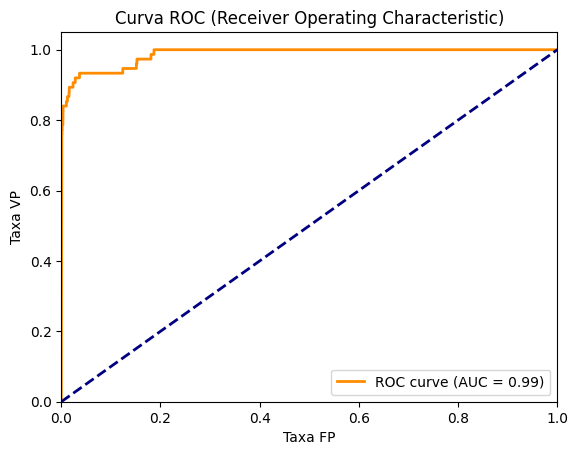

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, probabilidades) # já temos esses valores, portanto não precisamos recalculamos usando o SK-learn

roc_auc = auc(fpr, tpr)
# roc_auc = auc(taxa_FP, taxa_VP)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa FP')
plt.ylabel('Taxa VP')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

--/-- Exercício

1)Escolha do limiar adequado

Para selecionar um valor de limiar adequado, foi feita uma análise sistemática das taxas de verdadeiros positivos (TPR) e falsos positivos (FPR) para diferentes valores de limiar. Observou-se que, conforme o limiar aumenta, a taxa de falsos positivos diminui, enquanto a taxa de verdadeiros positivos se mantém constante até aproximadamente 0,60, começando a cair de forma gradual a partir desse ponto.

Ao comparar os valores, o limiar 0,64 apresentou um bom equilíbrio entre detecção de fraudes e controle de falsos alarmes. Nesse ponto, a taxa de verdadeiros positivos foi de 0,80, enquanto a taxa de falsos positivos caiu para 0,003375, representando uma redução significativa em relação ao valor padrão de 0,50 (FPR = 0,004746), com uma perda modesta de recall (de 0,84 para 0,80).

A escolha do limiar 0,64 é justificada porque:

Reduz consideravelmente a quantidade de falsos positivos, o que é importante para diminuir o número de alertas incorretos e a sobrecarga de revisões manuais;

Mantém uma taxa de detecção de fraudes ainda alta, evitando perdas significativas na identificação de transações fraudulentas;

Está em uma região da curva ROC que apresenta boa relação entre sensibilidade (TPR) e especificidade (1−FPR).

Portanto, o limiar de 0,64 foi adotado como valor final, por oferecer um equilíbrio adequado entre a detecção eficiente de fraudes e a minimização de alarmes falsos, considerando as características desbalanceadas do conjunto de dados.